In [ ]:

import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
from astropy.io import fits
import copy
import time
from datetime import timezone 

import ray

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, CenteredNorm
from matplotlib.patches import Circle, Rectangle
from matplotlib.gridspec import GridSpec

import esc_llowfsc_sim
from esc_llowfsc_sim.math_module import xp, xcipy, ensure_np_array
from esc_llowfsc_sim import utils, dm, iefc, shmim_utils, coro_utils
import esc_llowfsc_sim.esc_fraunhofer as esc

from magpyx.utils import ImageStream

model_params = utils.load_pickle(esc_llowfsc_sim.path/'data/example_fraunhofer_params_1K.pkl')
M = esc.single(**model_params)

/opt/conda/envs/llowfscSim310/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


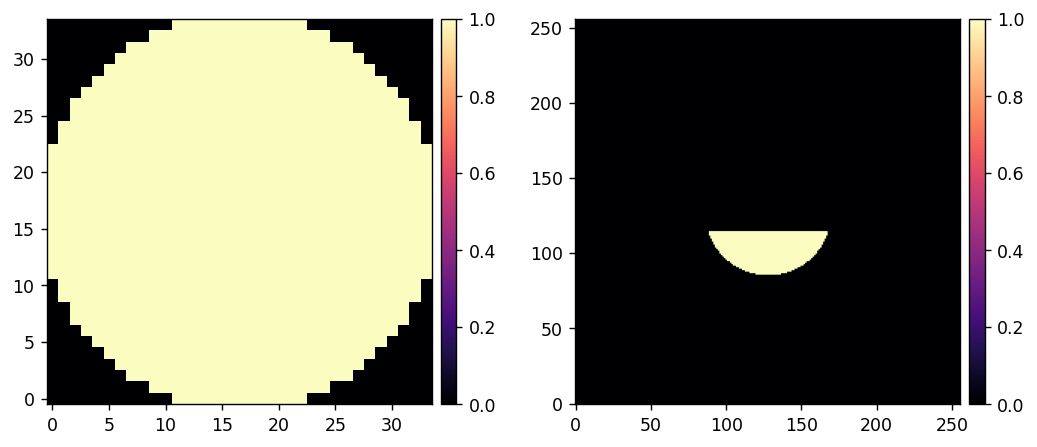

In [5]:
CAMSCI_STREAM = ImageStream('camscisim')
CAMSCI_STREAM = ImageStream('camscisim')
CAMSCI_SHUTTER_STREAM = ImageStream('camscishutter')
CAMSCI_EXPTIME_STREAM = ImageStream('camsciexptime')
CAMSCI_GAIN_STREAM = ImageStream('camscigain')
DM3_STREAM = ImageStream('dm00disp03')
FSM1_STREAM = ImageStream('fsm01')
FSM2_STREAM = ImageStream('fsm02')

iwa = 3
owa = 10

dm_mask = dm.create_mask(Nact=34, return_np=1)

dh_mask = utils.create_annular_focal_plane_mask(
    M.ncamsci,
    M.camsci_pxscl_lamDc,
    iwa, 
    owa,  
    edge=iwa,
    centering='odd', # odd or even
    rotation=90,
    x_shift=0,
    y_shift=0,
    return_np=1,
)

utils.imshow([dm_mask, dh_mask])
DM3_STREAM.write(np.zeros_like(dm_mask))

In [37]:
34/2 * 9.3/10.2 * M.lyot_ratio

13.950000000000001

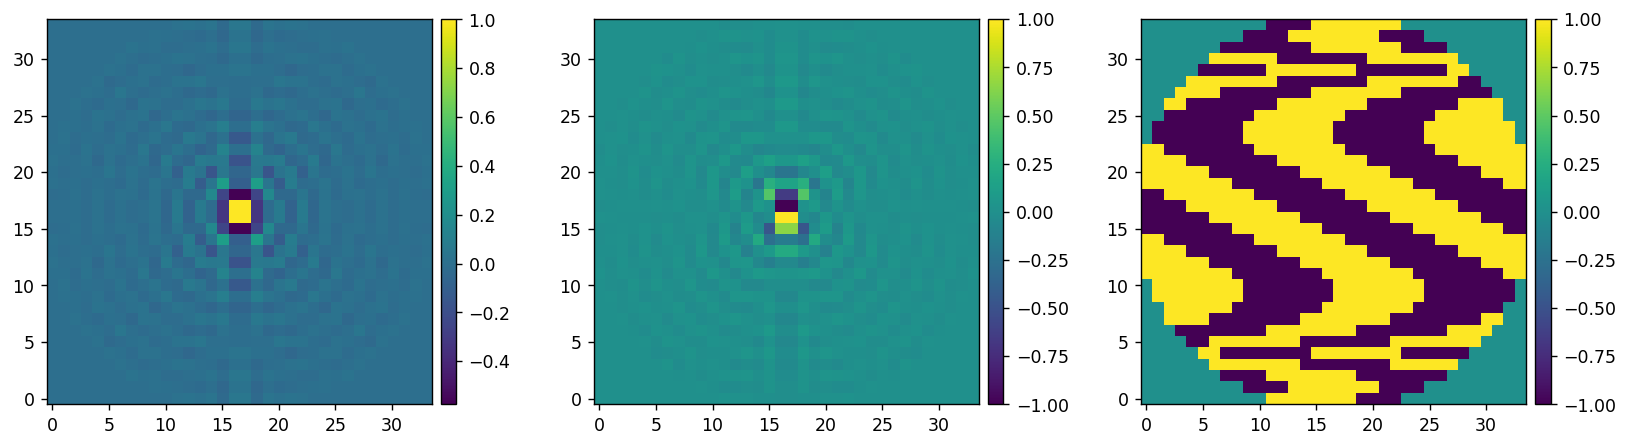

In [3]:
reload(utils)
reload(dm)
fourier_probes = dm.create_fourier_probes(
    dm_mask, 
    M.ncamsci, 
    M.camsci_pxscl_lamDc, 
    2,
    14, 
    rotation=90,
    use_weighting=True,
    nprobes=2,
    return_np=1, 
)

calib_modes = dm.create_hadamard_modes(dm_mask, return_np=1)

utils.imshow([fourier_probes[0], fourier_probes[1], calib_modes[8]], cmaps=3*['viridis'])

In [9]:
shmim_utils.write(CAMSCI_GAIN_STREAM, [100])

In [ ]:
ref_psf_exp_time, ref_psf_gain = (0.005, 0)

shmim_utils.write(CAMSCI_SHUTTER_STREAM, [0])
shmim_utils.write(CAMSCI_EXPTIME_STREAM, [ref_psf_exp_time])
shmim_utils.write(CAMSCI_GAIN_STREAM, [ref_psf_gain])

shmim_utils.write(FSM1_STREAM, [0, 50, 50])

shmim_utils.write(CAMSCI_SHUTTER_STREAM, [1])
time.sleep(0.5)
ref_psf_dark = shmim_utils.stack(CAMSCI_STREAM, 100)
shmim_utils.write(CAMSCI_SHUTTER_STREAM, [0])

ref_psf = shmim_utils.stack(CAMSCI_STREAM, 100)
ref_psf_ds = ref_psf - ref_psf_dark

ref_params = {
    'Imax':xp.max(ref_psf_ds),
    'exp_time':ref_psf_exp_time,
    'gain':ref_psf_gain, 
}

shmim_utils.write(FSM1_STREAM, [0, 0, 0])

utils.imshow(
    [ref_psf, ref_psf_dark, ref_psf_ds/ref_params['Imax']],
    titles=['Reference PSF', 'Reference PSF Dark Image', f'Dark Subtracted PSF\nImax = {ref_params["Imax"]:.2f}'],
    norms=[LogNorm(), None, LogNorm(1e-5)],
)

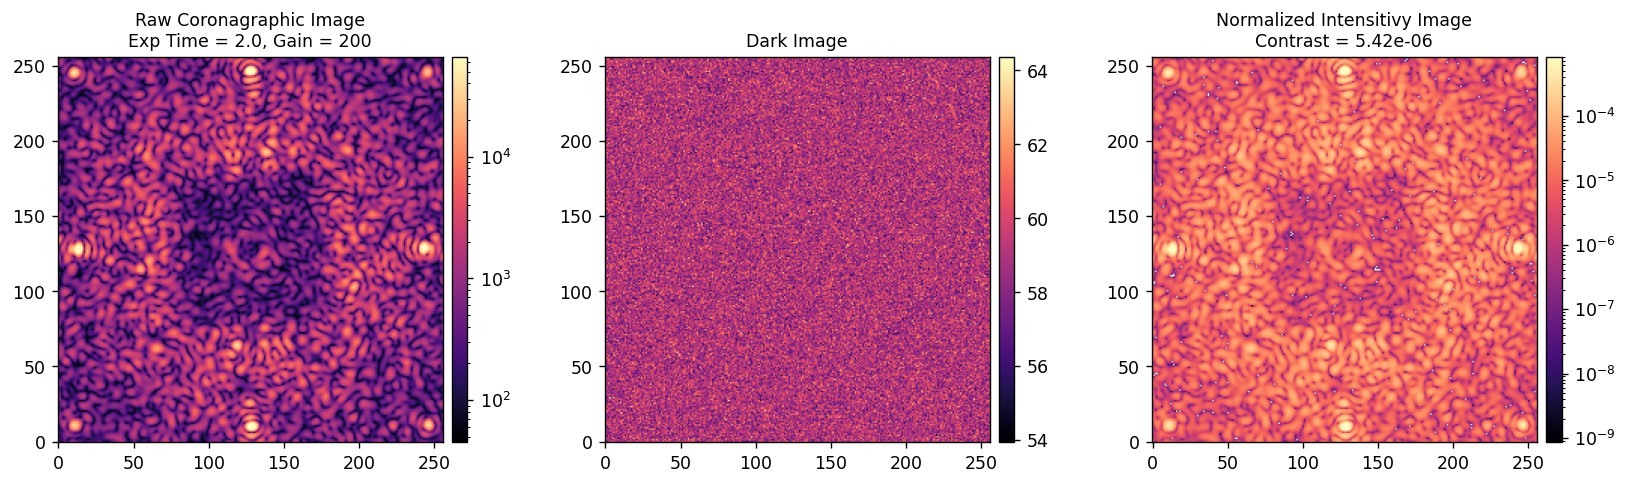

In [ ]:
reload(iefc)

coro_im_params = {
    'exp_time':2.0,
    'gain':200,
}

shmim_utils.write(CAMSCI_EXPTIME_STREAM, [coro_im_params['exp_time']])
shmim_utils.write(CAMSCI_GAIN_STREAM, [coro_im_params['gain']])

shmim_utils.write(CAMSCI_SHUTTER_STREAM, [1])
time.sleep(0.5)
coro_dark = shmim_utils.stack(CAMSCI_STREAM, 200)
shmim_utils.write(CAMSCI_SHUTTER_STREAM, [0])

coro_im = shmim_utils.stack(CAMSCI_STREAM, 10)
coro_im_ni0 = coro_utils.normalize_coro_im(coro_im, coro_im_params, ref_params, coro_dark)

contrast0 = coro_utils.compute_contrast(coro_im_ni0, dh_mask)

utils.imshow(
    [coro_im, coro_dark, coro_im_ni0],
    titles=[
        f'Raw Coronagraphic Image\nExp Time = {coro_im_params["exp_time"]}, Gain = {coro_im_params["gain"]}', 
        f'Dark Image',
        f'Normalized Intensitivy Image\nContrast = {contrast0:.2e}',
    ],
    norms=[LogNorm(), None, LogNorm()],
)

In [14]:
reload(iefc)
DM3_STREAM.write(np.zeros_like(dm_mask))

coro_im_params = {
    'exp_time':0.2,
    'gain':200,
}

shmim_utils.write(CAMSCI_EXPTIME_STREAM, [coro_im_params['exp_time']])
shmim_utils.write(CAMSCI_GAIN_STREAM, [coro_im_params['gain']])

# shmim_utils.write(CAMSCI_SHUTTER_STREAM, [1])
# time.sleep(0.5)
# coro_dark = shmim_utils.stack(CAMSCI_STREAM, 100)
# shmim_utils.write(CAMSCI_SHUTTER_STREAM, [0])

diff_ims = iefc.take_measurement(
    CAMSCI_STREAM,
    50, 
    DM3_STREAM,
    coro_im_params,
    ref_params,
    # coro_dark,
    # 0.0,
    fourier_probes,
    20e-9,
    plot=1,
)

In [22]:
DM3_STREAM.write(np.zeros_like(dm_mask))


In [15]:
reload(iefc)

DM3_STREAM.write(np.zeros_like(dm_mask))

calib_probe_amp = 20e-9
calib_mode_amp = 5e-9

coro_im_params = {
    'exp_time':0.2,
    'gain':200,
}

shmim_utils.write(CAMSCI_EXPTIME_STREAM, [coro_im_params['exp_time']])
shmim_utils.write(CAMSCI_GAIN_STREAM, [coro_im_params['gain']])

# shmim_utils.write(CAMSCI_SHUTTER_STREAM, [1])
# time.sleep(0.5)
# coro_dark = shmim_utils.stack(CAMSCI_STREAM, 100)
# shmim_utils.write(CAMSCI_SHUTTER_STREAM, [0])

response_matrix, response_cube = iefc.calibrate(
    CAMSCI_STREAM, 
    5,
    DM3_STREAM, 
    coro_im_params,
    ref_params,
    dh_mask, 
    calib_probe_amp, 
    fourier_probes, 
    calib_mode_amp, 
    calib_modes[:],
    delay=0.02,
    dark_im=0.0,
    scale_factors=None, 
    plot_responses=True, 
)


Calibrating iEFC...
	Calibrated mode 1024/1024 in 614.403s
Calibration complete.


In [16]:
reload(utils)
# iwa = 3
# owa = 15
# control_mask = utils.create_annular_focal_plane_mask(
#     M.ncamsci, 
#     M.camsci_pxscl_lamD, 
#     iwa, 
#     owa,  
#     edge=iwa,
#     rotation=90,
# )
# response_matrix = response_cube[:, :, control_mask.ravel()].reshape(calib_modes.shape[0], -1).T

# Compute a variety of control matrices so we can quickly switch between regularization values. 
cm20 = utils.beta_reg(response_matrix, -2, return_np=1)
cm25 = utils.beta_reg(response_matrix, -2.5, return_np=1)
cm30 = utils.beta_reg(response_matrix, -3, return_np=1)
cm35 = utils.beta_reg(response_matrix, -3.5, return_np=1)
cm40 = utils.beta_reg(response_matrix, -4, return_np=1)
cm45 = utils.beta_reg(response_matrix, -4.5, return_np=1)
cm50 = utils.beta_reg(response_matrix, -5, return_np=1)

In [17]:
DM3_STREAM.write(np.zeros(DM3_STREAM.shape))
iefc_data = {
    'images':[coro_im_ni0],
    'contrasts':[contrast0],
    'commands':[np.zeros_like(dm_mask)],
    'del_commands':[np.zeros_like(dm_mask)],
    'pixelscale':M.camsci_pxscl_lamDc,
    'control_mask':dh_mask, 
    'probes':fourier_probes,
}

Running iteration 9 / 10
Measuring dark hole state ...


Running iteration 10 / 10
Measuring dark hole state ...


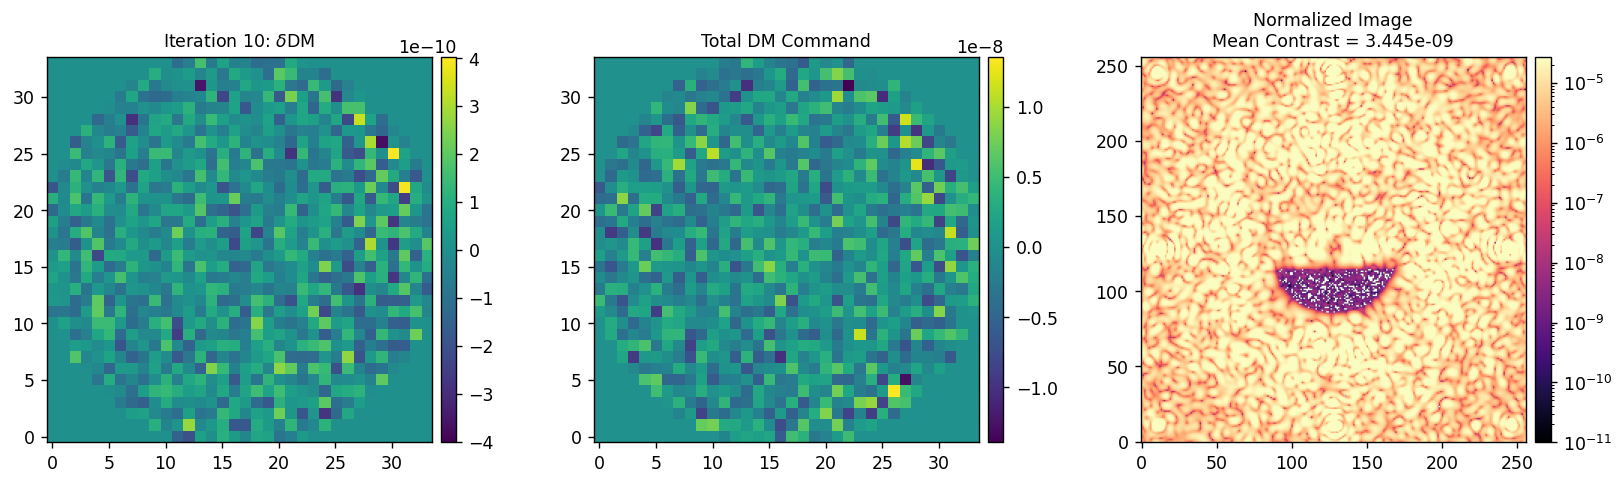

Completed 2 iterations in 4.339s.


In [24]:
reload(utils)
reload(iefc)

probe_amp = 2.5e-9
probe_amp = 1e-9
probe_amp = 0.5e-9
# probe_amp = 0.25e-9
# probe_amp = 0.1e-9

data = iefc.run(
    iefc_data,
    CAMSCI_STREAM,
    30,
    DM3_STREAM,
    coro_im_params,
    ref_params, 
    coro_dark, 
    # cm20,
    cm25,
    # cm40,
    # cm45,
    # cm50,
    probe_amp, 
    fourier_probes, 
    calib_modes,
    dh_mask,
    delay=0.02,
    num_iterations=2,
    gain=1.0, 
    leakage=0.0,
    plot_current=True,
    plot_all=True,
    vmin=1e-11,
)

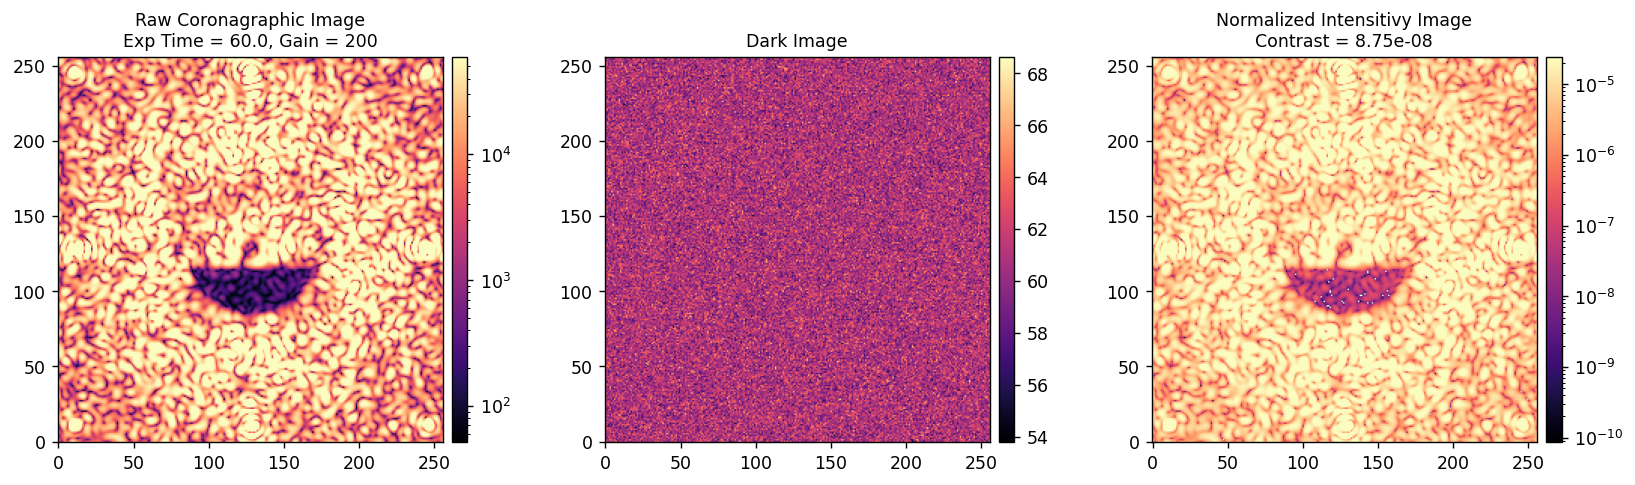

In [20]:
coro_im_params = {
    'exp_time':60.0,
    'gain':200,
}

shmim_utils.write(CAMSCI_EXPTIME_STREAM, [coro_im_params['exp_time']])
shmim_utils.write(CAMSCI_GAIN_STREAM, [coro_im_params['gain']])

shmim_utils.write(CAMSCI_SHUTTER_STREAM, [1])
time.sleep(0.5)
coro_dark = shmim_utils.stack(CAMSCI_STREAM, 100)
shmim_utils.write(CAMSCI_SHUTTER_STREAM, [0])

coro_im = shmim_utils.stack(CAMSCI_STREAM, 10)
coro_im_ni = iefc.normalize_coro_im(coro_im, coro_im_params, ref_params, coro_dark)

contrast = iefc.compute_contrast(coro_im_ni, dh_mask)

utils.imshow(
    [coro_im, coro_dark, coro_im_ni],
    titles=[
        f'Raw Coronagraphic Image\nExp Time = {coro_im_params["exp_time"]}, Gain = {coro_im_params["gain"]}', 
        f'Dark Image',
        f'Normalized Intensitivy Image\nContrast = {contrast:.2e}',
    ],
    norms=[LogNorm(), None, LogNorm()],
)

In [58]:
iefc_data.update({
    'response_matrix':response_matrix, 
    'response_cube':response_cube,
    'calib_modes':calib_modes,
    'calib_mode_amp':calib_mode_amp,
    'probe_modes':fourier_probes,
    'calib_probe_amp':calib_probe_amp,
})

utils.save_pickle('flight-sim-data-1K/flight_state_iefc_results_ff_offset_with_flat.pkl', iefc_data)


Saved data to:  flight-sim-data-1K/flight_state_iefc_results_ff_offset_with_flat.pkl


In [ ]:
DM_STREAM3.write(dm_zeros)

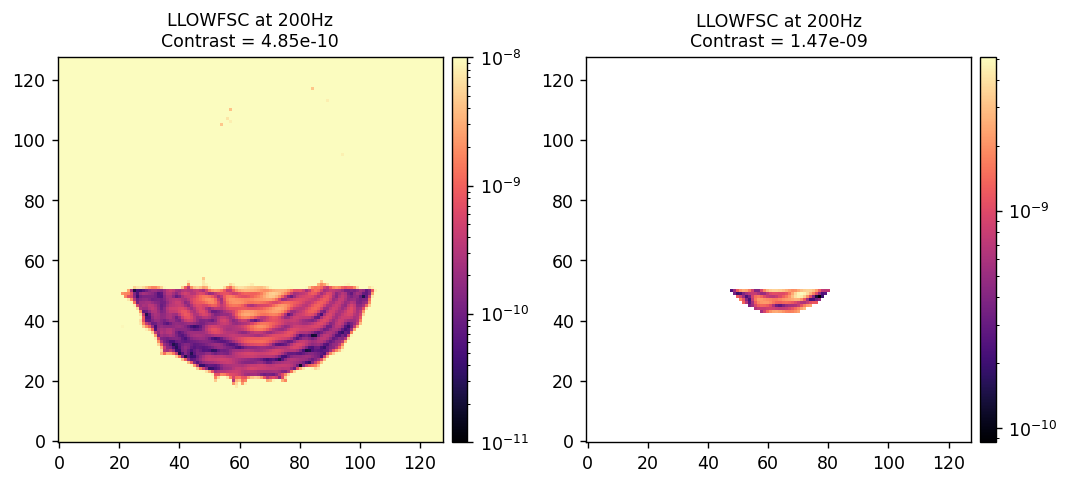

In [85]:
camsci_im = np.mean(CAMSCI_STREAM.grab_many(1000), axis=0)
contrast = np.mean(camsci_im[dh_mask])
contrast_3_5 = np.mean(camsci_im[coro_mask_3_5])

utils.imshow(
    [camsci_im, camsci_im*coro_mask_3_5],
    norms=[LogNorm(1e-11, 1e-8), LogNorm()],
    titles=[f'LLOWFSC at 200Hz\nContrast = {contrast:.2e}', f'LLOWFSC at 200Hz\nContrast = {contrast_3_5:.2e}']
)

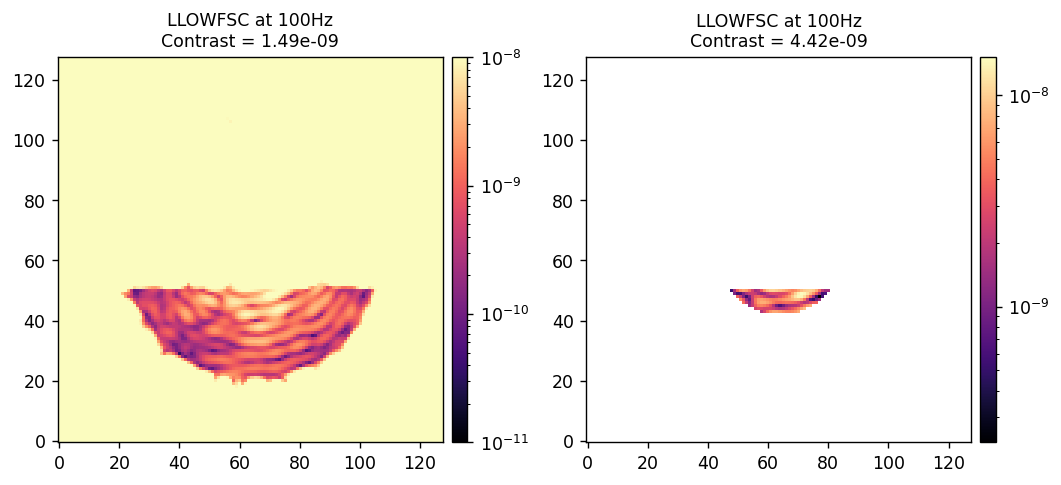

In [84]:
camsci_im = np.mean(CAMSCI_STREAM.grab_many(1000), axis=0)
contrast = np.mean(camsci_im[dh_mask])
contrast_3_5 = np.mean(camsci_im[coro_mask_3_5])

utils.imshow(
    [camsci_im, camsci_im*coro_mask_3_5],
    norms=[LogNorm(1e-11, 1e-8), LogNorm()],
    titles=[f'LLOWFSC at 100Hz\nContrast = {contrast:.2e}', f'LLOWFSC at 100Hz\nContrast = {contrast_3_5:.2e}']
)

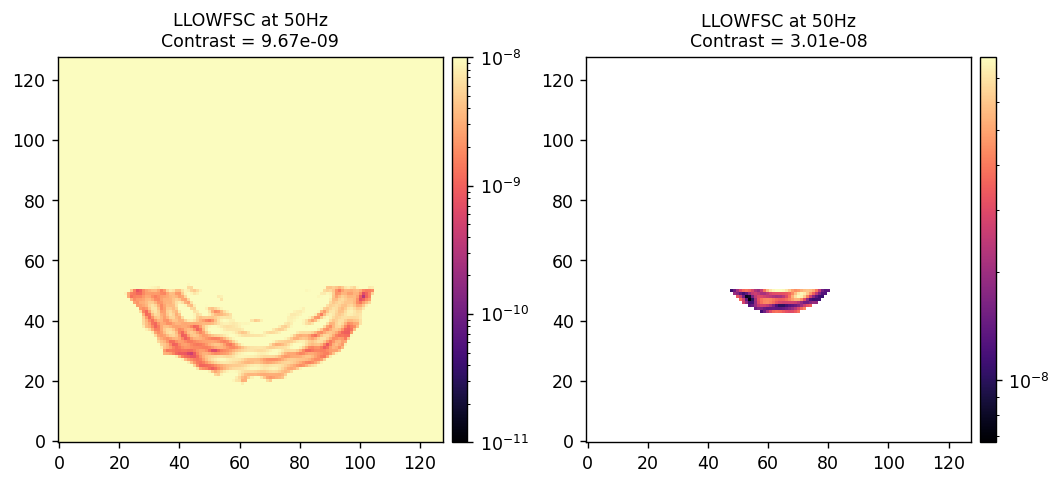

In [83]:
camsci_im = np.mean(CAMSCI_STREAM.grab_many(1000), axis=0)
contrast = np.mean(camsci_im[dh_mask])
contrast_3_5 = np.mean(camsci_im[coro_mask_3_5])

utils.imshow(
    [camsci_im, camsci_im*coro_mask_3_5],
    norms=[LogNorm(1e-11, 1e-8), LogNorm()],
    titles=[f'LLOWFSC at 50Hz\nContrast = {contrast:.2e}', f'LLOWFSC at 50Hz\nContrast = {contrast_3_5:.2e}']
)

# Load in and test previous iEFC data.

In [50]:
# iefc_data = utils.load_pickle('flight-sim-data/flight_state_iefc_results_1.pkl')
iefc_data = utils.load_pickle('flight-sim-data-1K/flight_state_iefc_results_ff_offset_with_flat.pkl')
iefc_commands = iefc_data['commands']
dh_mask = iefc_data['control_mask']

In [51]:
DM_STREAM3.write(iefc_commands[-1])